### Tarea K-Means
#### Daniel Espinosa 136981

Brief description: Segment a data set using k-means and train a classification model on each cluster. Compare performance with or without this pre-processing

El set de datos con el que se trabaja en este trabajo consiste de varias variables numéricas que describen información médica de una persona y la variable target binaria **Outcome** que dice si la persona tiene diabetes o no.

El objetivo del trabajo es comparar el desempeño de un modelo de clasificación sobre toda la información contra el desempeño de varios modelos del mismo tipo de clasificación entrenados con conjuntos de datos que han sido identificados como un cluster por el algoritmo K-means.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_csv("diabetes.csv",header=0, na_values = "?")
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [3]:
np.random.seed(923)

X_train, X_test, Y_train, Y_test = train_test_split(df[df.columns[0:-1]],df[df.columns[-1]], train_size=0.75)

#Hacer la vida más fácil usando matrices de numpy

X_trainM = X_train.as_matrix()
Y_trainM = Y_train.as_matrix()

X_testM = X_test.as_matrix()
Y_testM = Y_test.as_matrix()

/Users/danielespinosa/gitsome/claseMachineLearning/lib/python2.7/site-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Para hacer el modelo más simple, se utilizarán solamente las variables **Glucose**, **Insulin** y **BMI** para la predicción sin K-Means y para la agrupación por K-Means.

In [4]:
#seleccion de variables

glucose = X_trainM[:,1]
insulin = X_trainM[:,4]
bmi = X_trainM[:,5]

selected_train = np.column_stack((glucose,insulin,bmi))

glucose_t = X_testM[:,1]
insulin_t = X_testM[:,4]
bmi_t = X_testM[:,5]

selected_test = np.column_stack((glucose_t,insulin_t,bmi_t))

#Estandarizacion de los datos respecto a la media y desviacion estandar del
#set de entrenamiento

scaler = StandardScaler()

selected_train_scaled = scaler.fit_transform(selected_train)

selected_test_scaled = scaler.transform(selected_test)


### Desempeño del modelo de clasificación simple

In [5]:
clf = DecisionTreeClassifier()
clf = clf.fit(selected_train_scaled, Y_trainM)
Y_test_prediction = clf.predict(selected_test_scaled)
cm = confusion_matrix(Y_testM, Y_test_prediction)
tn, fp, fn, tp = confusion_matrix(Y_testM, Y_test_prediction).ravel()
cm

array([[97, 27],
       [28, 40]])

In [6]:
#Accuracy (num buenos/total)
accuracy = float(tp+tn) / float(tp + tn + fp + fn)
print("Accuracy: " + str(accuracy))
#Precision

precision = float(tp)/float(tp + fp)
print("Precision: " + str(precision))
#Recall

recall = float(tp)/float(tp + fn)
print("Recall: " + str(recall))

#F1

f1 = f1 = (2*(precision*recall))/(precision+recall)
print("F1 score: " + str(f1))

Accuracy: 0.713541666667
Precision: 0.597014925373
Recall: 0.588235294118
F1 score: 0.592592592593


Se puede ver que el modelo base no tiene un desempeño muy bueno aunque definitivamente es mucho mejor que adivinar.

### Modelo K-Means + Árboles de decisión para cada cluster

En esta sección se realizan los siguientes pasos:

+ Escoger el parámetro K para K-Means con el método del codo.
+ Correr K-Means sobre el set de entrenamiento y etiquetar las observaciones con el grupo al que resultaron pertenecer.
+ Entrenar un árbol de decisión para cada cluster.
+ 'Predecir' el cluster de cada observación del set de pruebas y etiquetarla usando el modelo K-Means (etiqueta del centroide más cercano) ya calculado.
+ Predecir la variable target con el modelo entrenado para el cluster al que parece pertenecer la observación.

In [7]:
inertias = []
xs = range(2,13)
for i in xs:
    kmeans_model = KMeans(n_clusters=i)
    kmeans_model.fit(selected_train_scaled)
    inertias.append(kmeans_model.inertia_)

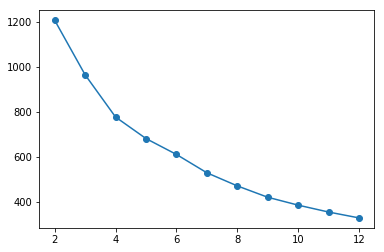

In [8]:
plt.plot(xs,inertias, '-o')
plt.show()

Utilizando el método del codo se selecciona **K = 6** pues parece un valor razonable después del cual la cohesión de los clusters deja de disminuir rápidamente. Es importante no escoger valores de K demasiado altos pues es fácil caer en *overfitting* al forzar la creación de demasiados clusters.

In [9]:
#Entrenar el modelo de k-means con K = 6

kmeans_model = KMeans(n_clusters=6)
train_cluster_labels = kmeans_model.fit_predict(selected_train_scaled)

#agregar las labels a entrenamiento
selected_train_scaled = np.column_stack((selected_train_scaled,train_cluster_labels))

#predecir las labels para pruebas
test_cluster_labels = kmeans_model.predict(selected_test_scaled)
selected_test_scaled = np.column_stack((selected_test_scaled,test_cluster_labels))


Entrenar los 6 modelos diferentes con los datos de entrenamiento agrupados.

In [10]:
#asociar Y_train con el X de entrenamiento

selected_train_scaled = np.column_stack((selected_train_scaled,Y_trainM))

#crear los clasificadores y entrenarlos
classifiers = []
for i in range(6):
    c = DecisionTreeClassifier()
    classifiers.append(c)
    current_cluster = np.array([x for x in selected_train_scaled if x[-2] == i])
    classifiers[i].fit(current_cluster[:,:-2], current_cluster[:,-1])

Predecir el **Outcome** para cada observación del set de pruebas con el árbol de decisión entrenado con el cluster al que más se parece la observación.

In [11]:
#Recorrer las observaciones del set de pruebas y clasificar con el modelo del cluster en el que caiga
Y_test_predictions = []

for x in selected_test_scaled:
    cluster_num = int(x[-1])
    sample = x[:-1].reshape(1, -1)
    Y_test_predictions.append(classifiers[cluster_num].predict(sample))
    
Y_test_predictions = np.array(Y_test_predictions)
    

### Desempeño del modelo compuesto

In [12]:
cm = confusion_matrix(Y_testM, Y_test_predictions)
tn, fp, fn, tp = confusion_matrix(Y_testM, Y_test_predictions).ravel()

cm

array([[98, 26],
       [26, 42]])

In [13]:
#Accuracy (num buenos/total)
accuracy = float(tp+tn) / float(tp + tn + fp + fn)
print("Accuracy: " + str(accuracy))
#Precision

precision = float(tp)/float(tp + fp)
print("Precision: " + str(precision))
#Recall

recall = float(tp)/float(tp + fn)
print("Recall: " + str(recall))

#F1

f1 = (2*(precision*recall))/(precision+recall)
print("F1 score: " + str(f1))

Accuracy: 0.729166666667
Precision: 0.617647058824
Recall: 0.617647058824
F1 score: 0.617647058824


### Comparación del desempeño de los modelos

|Métrica|**Modelo Base**|**Modelo compuesto**|
|---|---|---|
|**Accuracy**|0.713541666667|0.729166666667|
|**Precision**|0.597014925373|0.617647058824|
|**Recall**|0.588235294118|0.617647058824|
|**F1 Score**|0.592592592593|0.617647058824|

### Conclusiones

Para esta ejecución en particular, el modelo compuesto obtuvo mejores métricas de desempeño que el modelo simple.

La razón por la cual generalmente se obtienen mejores resultados al aplicar modelos de clasificación después de aplicar un algoritmo de agrupación es porque se segmenta a la población en grupos y así cada modelo de clasificación puede aprender los patrones específicos en cada cluster. El modelo compuesto resultante es más robusto pues ha pasado por más etapas de abstracción.

En general el dataset utilizado en este trabajo es uno difícil de predecir, además no tiene muchas observaciones por lo que los modelos de clasificación no tienen tantos ejemplos para aprender y cuando se segmenta a la población en clusters, cada modelo de clasificación tiene aún menos ejemplos para aprender, es probable que con un dataset más grande se puedan observar diferencias más significativas a favor del modelo híbrido.

Este trabajo demuestra como diferentes técnicas de aprendizaje de máquina, como aprendizaje supervisado y no supervisado se pueden combinar para resultar en un modelo más robusto.